# Evolution of commitment and level of participation in public goods games

### Import of library needed

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Union, List

from egttools.games import AbstractNPlayerGame
from egttools import sample_simplex, calculate_nb_states
from egttools.analytical import PairwiseComparison
from egttools.utils import calculate_stationary_distribution
from egttools.plotting import draw_invasion_diagram

### Definition of the PGG class

In [20]:
class PGGWithCommitment(AbstractNPlayerGame):
    def __init__(self, 
                 group_size: int,   # number of participants in the PGG
                 c: float,          # cost of cooperation
                 r: float,          # enhancing factor (multiplier)
                 eps: float,        # cost for propose a commitment
                 F: int,            # Minimum level of commitment required to cooperate
                 delta : float,     # cost to don't respect the commitment
                ):
        
        # Initialize superclass
        AbstractNPlayerGame.__init__(self, 5, group_size)
        
         # Parameters and configurations
        self.nb_strategies_ = 5
        self.group_size_ = group_size
        self.strategies = ["COMP", "C", "D", "FAKE", "FREE"]  # Propose ,Cooperate, Defect, Fake, Free
        self.c = c
        self.r = r
        self.eps = eps
        self.delta = delta
        self.F = F
        self.nb_group_configurations_ = self.nb_group_configurations()  # Calculate number of possible group configurations
        self.calculate_payoffs()    # Calculate payoffs for each strategy in different group configurations

    def get_strategy(self, group_composition: Union[List[int], np.ndarray], strategy: str):
        """Define actions based on each strategy."""
        
        contribute = False
        propose = False
        accept = False
        
        if strategy == "COMP": # Proposers 
            contribute = True
            propose = True
            accept = True
        elif strategy == "C": # Unconditional contributors
            contribute = True
            propose = False
            accept = True
        elif strategy == "D": # Defectors
            contribute = False
            propose = False
            accept = False
        elif strategy == "FAKE": # Fake committers
            contribute = False
            propose = False
            accept = True
        elif strategy == "FREE": # commitment free-riders
            if group_composition[0] > 0 :   # If there is a proposer, the FREE player contribute and accept
                contribute = True
                propose = False
                accept = True
        
        return contribute, propose, accept

    def play(self, group_composition: Union[List[int], np.ndarray], game_payoffs: np.ndarray) -> None:
        # Initialize payoffs for each strategy in the group
        game_payoffs[:] = 0.
        PROPOSER, COOPERATOR, DEFECTOR, FAKER, FREE  = 0, 1, 2, 3, 4

        # Calculate the number of each type of player in the group
        if group_composition[PROPOSER] == 0 :   # If no one propose, we don't have a FREE player -->  Classical PGG
            nb_contributors = group_composition[COOPERATOR]
            nb_acceptors = group_composition[FAKER] + nb_contributors
        else : #If one propose, we have can have a FREE player
            nb_contributors = group_composition[PROPOSER] + group_composition[COOPERATOR] + group_composition[FREE]
            nb_acceptors = group_composition[FAKER] + nb_contributors + group_composition[FREE]

        # Case 1: No proposer --> Original PGG
        if group_composition[PROPOSER] == 0 : # Node 5
            nb_contributors = group_composition[COOPERATOR]
            nb_defectors = group_composition[FAKER] + group_composition[DEFECTOR]
            nb_participants = nb_defectors + nb_contributors
            total_reward = self.r * self.c * nb_contributors 
            individual_reward = total_reward / max(nb_participants, 1) # Avoid division by zero

            for index, _ in enumerate(group_composition):
                contributes, proposes, accepts = self.get_strategy(group_composition, self.strategies[index])
                game_payoffs[index] += individual_reward
                if contributes :
                    game_payoffs[index] -= self.c 

        # Case 2: At least one proposer
        elif group_composition[PROPOSER] >= 1 : # Node 2
            if nb_acceptors > self.F :  # Minimum acceptance threshold
                # Compute payoffs for cooperation
                total_reward = self.r * self.c * nb_contributors
                individual_reward = total_reward / max(nb_acceptors, 1)

                for index, _ in enumerate(group_composition):
                    contributes, proposes, accepts = self.get_strategy(group_composition, self.strategies[index])
                    game_payoffs[index] += individual_reward
                    if contributes:
                        game_payoffs[index] -= self.c
                    if proposes:
                        game_payoffs[index] -= self.eps
                    if accepts and not contributes:
                        game_payoffs[index] -= self.delta  # Penalty for fake commitment
            else : 
                return # The PGG is not played
        
        # The PGG is not played
        else :
            return


    def calculate_payoffs(self) -> np.ndarray:
        """Calculate and store the payoffs for each strategy in the game."""
        
        # Initialize an array to store payoffs for each configuration
        payoffs_container = np.zeros(shape=(self.nb_strategies_,), dtype=np.float64)
        
        # Loop over all possible group configurations
        for i in range(self.nb_group_configurations_):
            # Generate a sample group composition
            group_composition = sample_simplex(i, self.group_size_, self.nb_strategies_)
            group_composition = np.array(group_composition, dtype=float)

            # Play the game with the given group composition
            self.play(group_composition, payoffs_container)

            # Update the payoff for each strategy based on this configuration
            for strategy_index, strategy_payoff in enumerate(payoffs_container):
                self.update_payoff(strategy_index, i, strategy_payoff)
                
            # Reset the payoff container for the next configuration
            payoffs_container[:] = 0

        return self.payoffs()

In [21]:
# Parameters of the Evolutionary Dynamics: They are kept constant throughout the whole paper
Z = 100 # population size
beta = .25 # strength of selection

In [22]:
# Parameters of the game:
group_size = 5

strategy_labels = ["COMP", "C", "D", "FAKE", "FREE"]
nb_strategies = len(strategy_labels)

c = 1.  # Not said explicitly in the paper
r = 4.
F = 2

eps = 0.25
delta = 2.

In [23]:
game = PGGWithCommitment(group_size, c, r, eps, F, delta)

In [24]:
evolver = PairwiseComparison(Z, game)
transition_matrix,fixation_probabilities = evolver.calculate_transition_and_fixation_matrix_sml(beta)
stationary_distribution = calculate_stationary_distribution(transition_matrix.transpose())

sd_avoid = stationary_distribution[0]

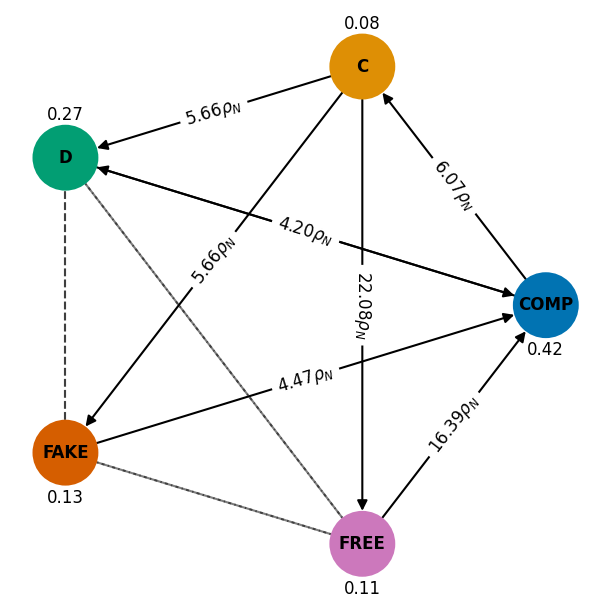

In [25]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
G = draw_invasion_diagram(strategy_labels,
                       1/Z, 
                       fixation_probabilities,
                       stationary_distribution,
                       node_size=1000, 
                       font_size_node_labels=8,
                       font_size_edge_labels=8,
                       font_size_sd_labels=8,
                       edge_width=1,
                       min_strategy_frequency=-0.1, 
                       ax=ax)
plt.axis('off')
plt.show() # display

# Figure 3

In [70]:
class PGGWithCommitment(AbstractNPlayerGame):
    def __init__(self, 
                 group_size: int,   # number of participants in the PGG
                 c: float,          # cost of cooperation
                 r: float,          # enhancing factor (multiplier)
                 eps: float,        # cost for propose a commitment
                 F: int,            # Minimum level of commitment required to cooperate
                 delta : float,     # cost to don't respect the commitment
                ):
        
        # Initialize superclass
        AbstractNPlayerGame.__init__(self, 9, group_size)
        
         # Parameters and configurations
        self.group_size_ = group_size
        self.strategies = ["COMP1", "COMP2", "COMP3", "COMP4", "COMP5", "C", "D", "FAKE", "FREE"]
        self.nb_strategies_ = len(self.strategies)
        self.c = c
        self.r = r
        self.eps = eps
        self.delta = delta
        self.F = F
        self.nb_group_configurations_ = self.nb_group_configurations()  # Calculate number of possible group configurations
        self.calculate_payoffs()    # Calculate payoffs for each strategy in different group configurations

    def get_strategy(self, group_composition: Union[List[int], np.ndarray], strategy: str):
        """Définit les actions en fonction de la stratégie."""
        contribute = False
        propose = False
        accept = False

        if "COMP" in strategy:  # Vérifier si c'est une stratégie COMPF
            F_level = int(strategy.replace("COMP", ""))
            propose = True
            accept = True
            # Contribuer seulement si le seuil F est atteint
            if group_composition[0] >= F_level:  
                contribute = True
        elif strategy == "C":  # Coopérateur inconditionnel
            contribute = True
            propose = False
            accept = True
        elif strategy == "D":  # Défecteur
            contribute = False
            propose = False
            accept = False
        elif strategy == "FAKE":  # Faux engageant
            contribute = False
            propose = False
            accept = True
        elif strategy == "FREE":  # Opportuniste
            if group_composition[0] > 0:  # Coopère si quelqu’un propose
                contribute = True
                accept = True

        return contribute, propose, accept

    def play(self, group_composition: Union[List[int], np.ndarray], game_payoffs: np.ndarray) -> None:
        # Initialize payoffs for each strategy in the group
        game_payoffs[:] = 0.
        PROPOSER, COOPERATOR, DEFECTOR, FAKER, FREE  = 0, 1, 2, 3, 4

        # Calculate the number of each type of player in the group
        if group_composition[PROPOSER] == 0 :   # If no one propose, we don't have a FREE player -->  Classical PGG
            nb_contributors = group_composition[COOPERATOR]
            nb_acceptors = group_composition[FAKER] + nb_contributors
        else : #If one propose, we have can have a FREE player
            nb_contributors = group_composition[PROPOSER] + group_composition[COOPERATOR] + group_composition[FREE]
            nb_acceptors = group_composition[FAKER] + nb_contributors + group_composition[FREE]

        # Case 1: No proposer --> Original PGG
        if group_composition[PROPOSER] == 0 : # Node 5
            nb_contributors = group_composition[COOPERATOR]
            nb_defectors = group_composition[FAKER] + group_composition[DEFECTOR]
            nb_participants = nb_defectors + nb_contributors
            total_reward = self.r * self.c * nb_contributors 
            individual_reward = total_reward / max(nb_participants, 1) # Avoid division by zero

            for index, _ in enumerate(group_composition):
                contributes, proposes, accepts = self.get_strategy(group_composition, self.strategies[index])
                game_payoffs[index] += individual_reward
                if contributes :
                    game_payoffs[index] -= self.c 

        # Case 2: At least one proposer
        elif group_composition[PROPOSER] >= 1 : # Node 2
            if nb_acceptors > self.F :  # Minimum acceptance threshold
                # Compute payoffs for cooperation
                total_reward = self.r * self.c * nb_contributors
                individual_reward = total_reward / max(nb_acceptors, 1)

                for index, _ in enumerate(group_composition):
                    contributes, proposes, accepts = self.get_strategy(group_composition, self.strategies[index])
                    game_payoffs[index] += individual_reward
                    if contributes:
                        game_payoffs[index] -= self.c
                    if proposes:
                        game_payoffs[index] -= self.eps
                    if accepts and not contributes:
                        game_payoffs[index] -= self.delta  # Penalty for fake commitment
            else : 
                return # The PGG is not played
        
        # The PGG is not played
        else :
            return


    def calculate_payoffs(self) -> np.ndarray:
        """Calculate and store the payoffs for each strategy in the game."""
        
        # Initialize an array to store payoffs for each configuration
        payoffs_container = np.zeros(shape=(self.nb_strategies_,), dtype=np.float64)
        
        # Loop over all possible group configurations
        for i in range(self.nb_group_configurations_):
            # Generate a sample group composition
            group_composition = sample_simplex(i, self.group_size_, self.nb_strategies_)
            group_composition = np.array(group_composition, dtype=float)

            # Play the game with the given group composition
            self.play(group_composition, payoffs_container)

            # Update the payoff for each strategy based on this configuration
            for strategy_index, strategy_payoff in enumerate(payoffs_container):
                self.update_payoff(strategy_index, i, strategy_payoff)
                
            # Reset the payoff container for the next configuration
            payoffs_container[:] = 0

        return self.payoffs()


In [71]:
# Parameters of the game:
strategy_labels = ["COMP1", "COMP2", "COMP3", "COMP4", "COMP5", "C", "D", "FAKE", "FREE"]
nb_strategies = len(strategy_labels)
F=2

In [72]:
game = PGGWithCommitment(group_size, c, r, eps, F, delta)
evolver = PairwiseComparison(Z, game)
transition_matrix,fixation_probabilities = evolver.calculate_transition_and_fixation_matrix_sml(beta)
stationary_distribution = calculate_stationary_distribution(transition_matrix.transpose())

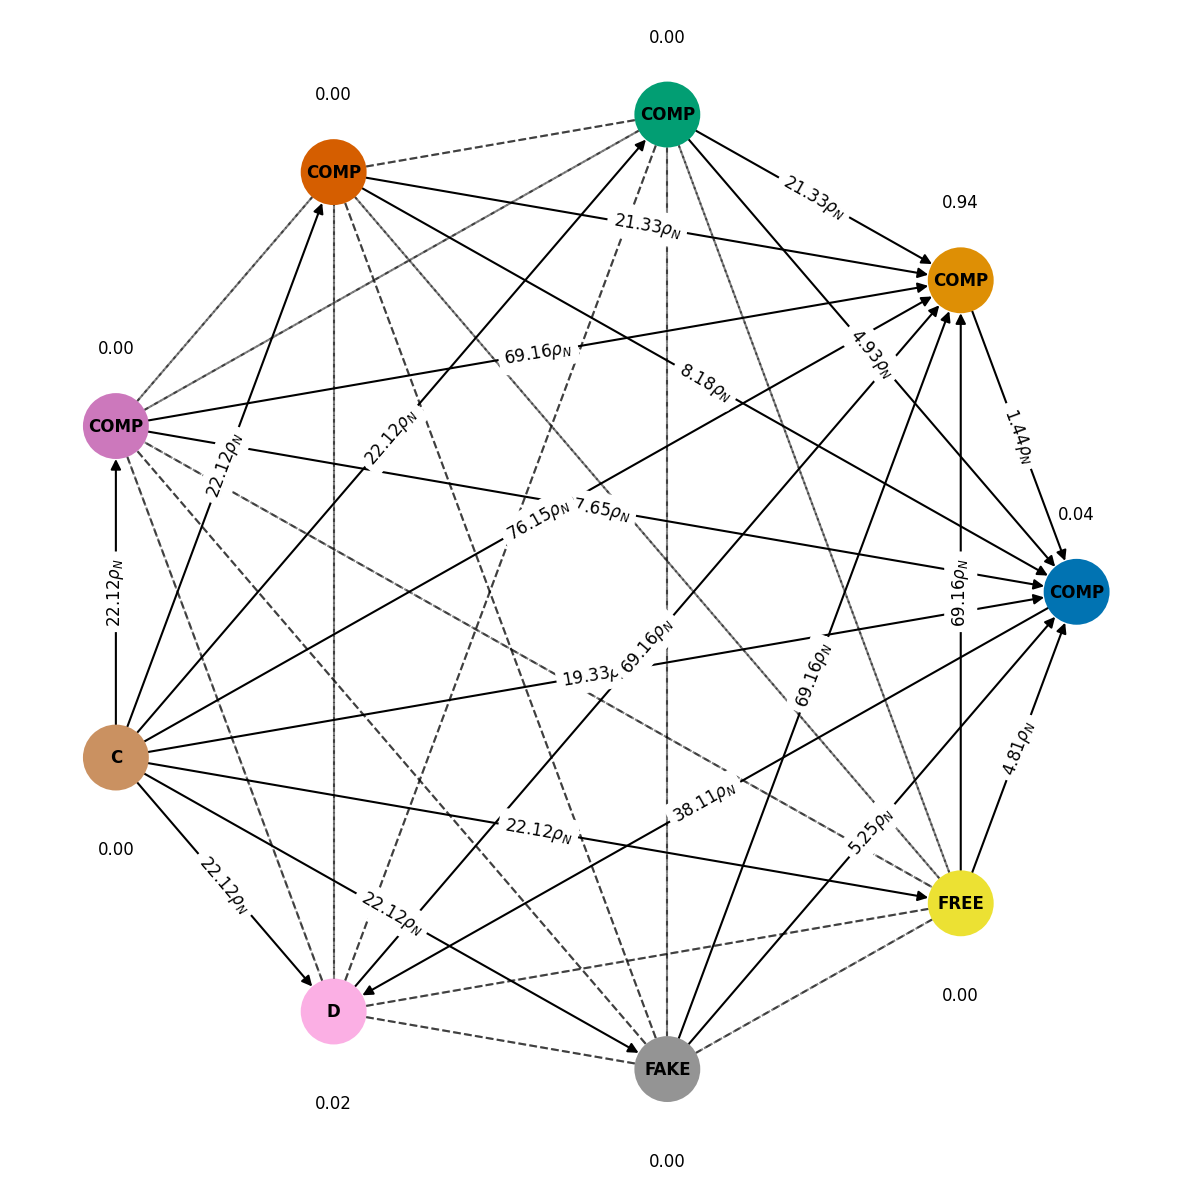

In [75]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=150)
G = draw_invasion_diagram(strategy_labels,
                       1/Z, 
                       fixation_probabilities,
                       stationary_distribution,
                       node_size=1000, 
                       font_size_node_labels=8,
                       font_size_edge_labels=8,
                       font_size_sd_labels=8,
                       edge_width=1,
                       min_strategy_frequency=-0.1, 
                       ax=ax)
plt.axis('off')
plt.show() # display

In [76]:
nb_points = 7
eps_values = np.linspace(0., 1., nb_points)
r_values = np.linspace(2., 5., nb_points)

avoid_frequency = np.zeros((nb_points, nb_points), dtype = float)

for i, eps in enumerate(eps_values):
    for j, r in enumerate(r_values):
        game = PGGWithCommitment(group_size, c, r, eps, F, delta)
        evolver = PairwiseComparison(Z, game)
        transition_matrix,_ = evolver.calculate_transition_and_fixation_matrix_sml(beta)
        stationary_distribution = calculate_stationary_distribution(transition_matrix.transpose())
        
        avoid_frequency[i,j] = stationary_distribution[0]

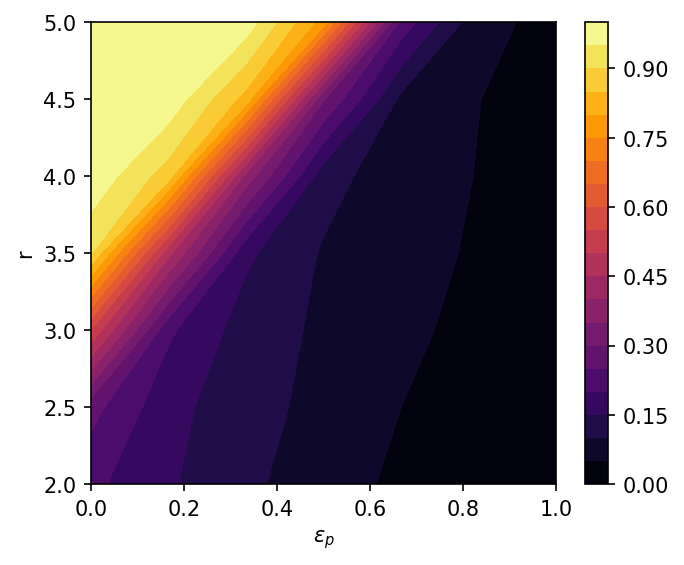

In [77]:
# Define the contour levels between 0 and 1
levels = np.linspace(0., 1., 21)

fig, ax = plt.subplots(figsize= (5,4), dpi=150)
tmp = ax.contourf(eps_values, r_values, avoid_frequency.T, levels=levels, cmap='inferno', vmin = 0., vmax = 1.,)
ax.set_xlabel(r'$\epsilon_p$')
ax.set_ylabel("r")
fig.colorbar(tmp,orientation='vertical',)

plt.show()